# Descipcion variables
## ImageData

### 1. **Condition of the House**
- **Field**: `ImageData.c1c6`
- **Description**: Related to the condition of the house, i.e., "How new and well-maintained it is."
- **Details**: 
  - Score summarizing solely the condition of the property.
  - Scale: 1.0 (Brand New) to 6.0 (Disrepair), with 1 decimal.

### 2. **Quality of the House**
- **Field**: `ImageData.q1q6`
- **Description**: Related to the quality of the house, i.e., "How luxurious or economical are the construction and finishings of the house."
- **Details**: 
  - Score summarizing solely the quality of construction of the property.
  - Scale: 1.0 (Luxury) to 6.0 (Substandard), with 1 decimal.

---

### 3. **Unique Features Identified**
- **Field**: `ImageData.features_reso`
- **Description**: A list of all the unique features identified in the property by Restb.ai’s RESO feature detection solution.
- **Details**: Features are defined as per the RESO data dictionary.

---

### 4. **Rooms Identified**
- **Field**: `ImageData.room_type_reso`
- **Description**: A list of all the rooms as defined by the RESO data dictionary, identified in the property.

---

### 5. **Exterior Style**
- **Field**: `ImageData.style.exterior`
- **Description**: Top prediction of the exterior style solution.

---

### 6. **Stories/Floors**
- **Field**: `ImageData.style.stories`
- **Description**: Top prediction of the number of stories or floors from the available photos.


## Listing Data

### Characteristics

#### 1. **Lot Features**
- **Field**: `Characteristics.LotFeatures`
- **Description**: A list of features or a description of the lot included in the sale/lease.

#### 2. **Lot Size**
- **Field**: `Characteristics.LotSizeSquareFeet`
- **Description**: The total square footage of the lot.

---

### Listing Details

#### 3. **Close Date**
- **Field**: `Listing.Dates.CloseDate`
- **Description**: The date the purchase agreement was fulfilled.

#### 4. **Listing ID**
- **Field**: `Listing.ListingId`
- **Description**: The well-known identifier for the listing.

#### 5. **Close Price**
- **Field**: `Listing.Price.ClosePrice`
- **Description**: The amount of money paid by the purchaser to the seller for the property under the agreement.

---

### Location Information

#### 6. **City**
- **Field**: `Location.Address.City`
- **Description**: The city in the listing address.

#### 7. **County or Parish**
- **Field**: `Location.Address.CountyOrParish`
- **Description**: The county, parish, or other regional authority.

#### 8. **Postal Code**
- **Field**: `Location.Address.PostalCode`
- **Description**: The postal code portion of a street or mailing address.

#### 9. **Postal Code Plus 4**
- **Field**: `Location.Address.PostalCodePlus4`
- **Description**: The last four digits of a nine-digit U.S. ZIP Code.

#### 10. **State or Province**
- **Field**: `Location.Address.StateOrProvince`
- **Description**: Text field containing the accepted postal abbreviation for the state or province.

#### 11. **Street Direction Prefix**
- **Field**: `Location.Address.StreetDirectionPrefix`
- **Description**: The direction indicator that precedes the listed property's street name.

#### 12. **Street Direction Suffix**
- **Field**: `Location.Address.StreetDirectionSuffix`
- **Description**: The direction indicator that follows the listed property's street address.

#### 13. **Street Name**
- **Field**: `Location.Address.StreetName`
- **Description**: The street name portion of a listed property's street address.

#### 14. **Street Number**
- **Field**: `Location.Address.StreetNumber`
- **Description**: The street number portion of a listed property's street address.

#### 15. **Street Suffix**
- **Field**: `Location.Address.StreetSuffix`
- **Description**: The suffix portion of a listed property's street address.

#### 16. **Unit Number**
- **Field**: `Location.Address.UnitNumber`
#- **Description**: A text field containing the unit number or portion of a larger building or complex (e.g., Apt G, #55).

#### 17. **Unparsed Address**
- **Field**: `Location.Address.UnparsedAddress`
- **Description**: A text representation of the address with the full civic location as a single entity.

#### 18. **Subdivision Name**
- **Field**: `Location.Area.SubdivisionName`
- **Description**: A neighborhood, community, complex, or builder tract.

#### 19. **High School District**
- **Field**: `Location.School.HighSchoolDistrict`
- **Description**: The name of the high school district having a catchment area that includes the associated property.

---

### Property Information

#### 20. **Property Type**
- **Field**: `Property.PropertyType`
- **Description**: A list of types of properties (e.g., Residential, Lease, Income, Land, Mobile, Commercial Sale).

---

### Structure Information

#### 21. **Basement**
- **Field**: `Structure.Basement`
- **Description**: A list of information and features about the basement (e.g., None/Slab, Finished, Crawl Space).

#### 22. **Full Bathrooms**
- **Field**: `Structure.BathroomsFull`
- **Description**: A room containing all four elements of a bath: toilet, sink, bathtub, shower head.

#### 23. **Half Bathrooms**
- **Field**: `Structure.BathroomsHalf`
- **Description**: A room containing two elements of a bath: toilet and sink.

#### 24. **Total Bedrooms**
- **Field**: `Structure.BedroomsTotal`
- **Description**: The total number of bedrooms in the dwelling.

#### 25. **Below Grade Finished Area**
- **Field**: `Structure.BelowGradeFinishedArea`
- **Description**: The finished area within the structure that is below ground.

#### 26. **Below Grade Unfinished Area**
- **Field**: `Structure.BelowGradeUnfinishedArea`
- **Description**: The unfinished area within the structure that is below ground.

#### 27. **Cooling**
- **Field**: `Structure.Cooling`
- **Description**: A list des cribing the cooling or air conditioning features of the property.

#### 28. **Fireplaces**
- **Field**: `Structure.FireplacesTotal`
- **Description**: Indicates whether or not the property includes a fireplace.

#### 29. **Garage Spaces**
- **Field**: `Structure.GarageSpaces`
- **Description**: The number of spaces in the garage(s).

#### 30. **Heating**
- **Field**: `Structure.Heating`
- **Description**: A list describing the heating features of the property.

#### 31. **Living Area**
- **Field**: `Structure.LivingArea`
- **Description**: The total livable area within the structure.

#### 32. **New Construction**
- **Field**: `Structure.NewConstructionYN`
- **Description**: Indicates whether or not the property is newly constructed.

#### 33. **Parking Features**
- **Field**: `Structure.ParkingFeatures`
- **Description**: A list of features about or a description of the parking included in the sale/lease.

#### 34. **Total Rooms**
- **Field**: `Structure.Rooms.RoomsTotal`
- **Description**: The number of rooms in a dwelling.

#### 35. **Year Built**
- **Field**: `Structure.YearBuilt`
- **Description**: The year the property was first granted an occupancy permit.

---

### Tax Information

#### 36. **Zoning**
- **Field**: `Tax.Zoning`
- **Description**: A division of the city or county into areas of different permissible land uses.

---

### Unit Types

#### 37. **Unit Type**
- **Field**: `UnitTypes.UnitTypeType`
- **Description**: A list of possible unit types (e.g., 1 Bedroom, 2 Bedroom, Studio, Loft, etc.).


## Census Data

#### 1. **Census Block**
- **Field**: `Location.Address.CensusBlock`
- **Description**: The smallest geographic unit used by the United States Census Bureau for tabulation of 100-percent data.

#### 2. **Census Tract**
- **Field**: `Location.Address.CensusTract`
- **Description**: A geographic region defined for the purpose of taking a census.

---

### Geographic Information System (GIS)

#### 3. **Latitude**
- **Field**: `Location.GIS.Latitude`
- **Description**: The geographic latitude of some reference point on the property, specified in degrees and decimal parts.

#### 4. **Longitude**
- **Field**: `Location.GIS.Longitude`
- **Description**: The geographic longitude of some reference point on the property, specified in degrees and decimal parts.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import requests
from bs4 import BeautifulSoup

from sklearn.model_selection import train_test_split, cross_val_score

sns.set()
pd.set_option('display.precision', 3)

import warnings

warnings.filterwarnings('ignore')

### Reading and fusion of the sets

In [2]:
# Leemos del csv
df_train = pd.read_csv("../train.csv", header= 0, delimiter = ',')
df_test = pd.read_csv("../test.csv",  header= 0, delimiter = ',')

df_train['origin'] = 'train'
df_test['origin'] = 'test'

df_combined = pd.concat([df_train, df_test], ignore_index=True)


In [3]:
# remove spaces and symbols to avoid problems with statsmodel GLM
df_combined.columns = [c.lower().strip().replace(' ','_').replace('/','_').replace('-','_') 
                                for c in df_combined.columns] 

renaming = {
    'characteristics.lotfeatures': 'lot_features',
    'characteristics.lotsizesquarefeet': 'lot_size_sqft',
    'imagedata.c1c6.summary.bathroom': 'c_bathroom',
    'imagedata.c1c6.summary.exterior': 'c_exterior',
    'imagedata.c1c6.summary.interior': 'c_interior',
    'imagedata.c1c6.summary.kitchen': 'c_kitchen',
    'imagedata.c1c6.summary.property': 'c_property',
    'imagedata.features_reso.results': 'features_reso',
    'imagedata.q1q6.summary.bathroom': 'q_bathroom',
    'imagedata.q1q6.summary.exterior': 'q_exterior',
    'imagedata.q1q6.summary.interior': 'q_interior',
    'imagedata.q1q6.summary.kitchen': 'q_kitchen',
    'imagedata.q1q6.summary.property': 'q_property',
    'imagedata.room_type_reso.results': 'room_type_reso',
    'imagedata.style.exterior.summary.label': 'style_exterior',
    'imagedata.style.stories.summary.label': 'style_stories',
    'listing.dates.closedate': 'close_date',
    'listing.listingid': 'listing_id',
    'listing.price.closeprice': 'close_price',
    'location.address.censusblock': 'census_block',
    'location.address.censustract': 'census_tract',
    'location.address.city': 'city',
    'location.address.countyorparish': 'county_or_parish',
    'location.address.postalcode': 'postal_code',
    'location.address.postalcodeplus4': 'postal_code_plus4',
    'location.address.stateorprovince': 'state_or_province',
    'location.address.streetdirectionprefix': 'street_direction_prefix',
    'location.address.streetdirectionsuffix': 'street_direction_suffix',
    'location.address.streetname': 'street_name',
    'location.address.streetnumber': 'street_number',
    'location.address.streetsuffix': 'street_suffix',
    'location.address.unitnumber': 'unit_number',
    'location.address.unparsedaddress': 'unparsed_address',
    'location.area.subdivisionname': 'subdivision_name',
    'location.gis.latitude': 'latitude',
    'location.gis.longitude': 'longitude',
    'location.school.highschooldistrict': 'high_school_district',
    'property.propertytype': 'property_type',
    'structure.basement': 'basement',
    'structure.bathroomsfull': 'bathrooms_full',
    'structure.bathroomshalf': 'bathrooms_half',
    'structure.bedroomstotal': 'bedrooms_total',
    'structure.belowgradefinishedarea': 'below_grade_finished_area',
    'structure.belowgradeunfinishedarea': 'below_grade_unfinished_area',
    'structure.cooling': 'cooling',
    'structure.fireplacestotal': 'fireplaces_total',
    'structure.garagespaces': 'garage_spaces',
    'structure.heating': 'heating',
    'structure.livingarea': 'living_area',
    'structure.newconstructionyn': 'new_construction',
    'structure.parkingfeatures': 'parking_features',
    'structure.rooms.roomstotal': 'rooms_total',
    'structure.yearbuilt': 'year_built',
    'tax.zoning': 'zoning',
    'unittypes.unittypetype': 'unit_type'
}

df_combined.rename(columns=renaming, inplace=True)

categorical_columns = df_combined.select_dtypes(include=['category']).columns.tolist()

# peek into the data
df_combined.head()

,lot_features,lot_size_sqft,c_bathroom,c_exterior,c_interior,c_kitchen,c_property,features_reso,q_bathroom,q_exterior,...,fireplaces_total,garage_spaces,heating,living_area,new_construction,parking_features,rooms_total,year_built,zoning,unit_type
0,NaN,3200.0,NaN,NaN,NaN,NaN,NaN,"['Cooling.CeilingFans', 'Flooring.Carpet', 'Fl...",NaN,NaN,...,NaN,NaN,NaN,NaN,False,NaN,NaN,0.0,commr,NaN
1,NaN,NaN,NaN,3.8,3.7,3.8,3.8,"['Appliances.GasRange', 'Appliances.Range', 'A...",NaN,4.2,...,NaN,NaN,['natural gas'],3175.0,False,['off alley'],6.0,NaN,NaN,NaN
2,NaN,18750.0,NaN,NaN,NaN,NaN,NaN,"['Flooring.Carpet', 'ParkingFeatures.Garage', ...",NaN,NaN,...,NaN,NaN,NaN,NaN,False,NaN,NaN,1926.0,commr,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"['CommunityFeatures.Lake', 'WaterfrontFeatures...",NaN,NaN,...,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,agric,NaN
4,"['horses allowed', 'paddock', 'pond(s)']",NaN,NaN,3.6,NaN,NaN,3.6,"['Appliances.Refrigerator', 'Appliances.Microw...",NaN,4.2,...,NaN,NaN,['other'],0.0,False,"['unassigned', 'off street']",4.0,2006.0,NaN,NaN


## Estadística descriptiva básica

A continuación vemos como hay una mezcla de variables categóricas y numéricas, y la variable objetivo es: **listing.price.closeprice**

In [4]:
df_combined.info();

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107437 entries, 0 to 107436
Data columns (total 55 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   lot_features                 42020 non-null   object 
 1   lot_size_sqft                1690 non-null    float64
 2   c_bathroom                   90744 non-null   float64
 3   c_exterior                   87789 non-null   float64
 4   c_interior                   93597 non-null   float64
 5   c_kitchen                    92320 non-null   float64
 6   c_property                   103055 non-null  float64
 7   features_reso                104780 non-null  object 
 8   q_bathroom                   90708 non-null   float64
 9   q_exterior                   82565 non-null   float64
 10  q_interior                   93589 non-null   float64
 11  q_kitchen                    92292 non-null   float64
 12  q_property                   101798 non-null  float64
 13 

In [5]:
df_combined.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
lot_features,42020,5106,['fenced yard'],8370,NaN,NaN,NaN,NaN,NaN,NaN,NaN
lot_size_sqft,1690.0,NaN,NaN,NaN,59491.451,478465.211,0.0,3743.75,8712.0,24520.75,9999999.0
c_bathroom,90744.0,NaN,NaN,NaN,3.116,0.724,1.0,2.8,3.2,3.6,6.0
c_exterior,87789.0,NaN,NaN,NaN,3.309,0.676,1.0,3.1,3.4,3.7,6.0
c_interior,93597.0,NaN,NaN,NaN,3.211,0.677,1.0,2.9,3.3,3.6,6.0
c_kitchen,92320.0,NaN,NaN,NaN,3.117,0.744,1.0,2.8,3.2,3.6,6.0
c_property,103055.0,NaN,NaN,NaN,3.183,0.682,1.0,2.9,3.2,3.6,6.0
features_reso,104780,94437,['Levels.Two'],1209,NaN,NaN,NaN,NaN,NaN,NaN,NaN
q_bathroom,90708.0,NaN,NaN,NaN,3.312,0.508,1.0,3.0,3.3,3.7,5.1
q_exterior,82565.0,NaN,NaN,NaN,3.499,0.594,1.0,3.1,3.5,3.9,5.4


## Visualización básica

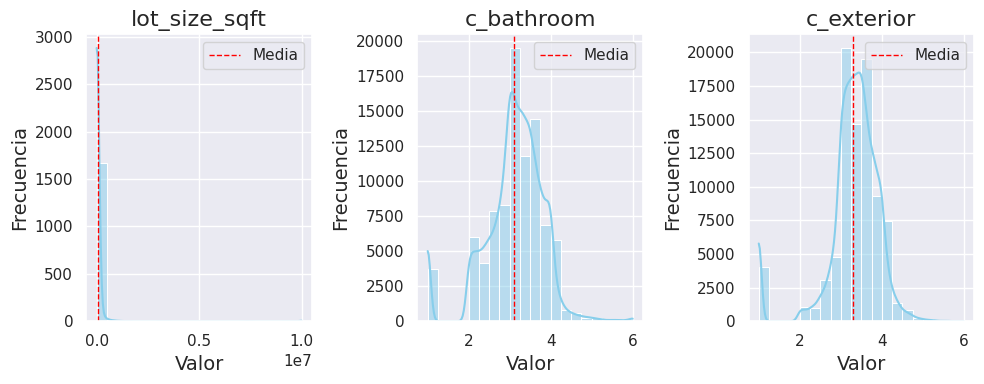

In [6]:
fig, axes = plt.subplots(1,3,figsize=(10,4))

# We will not plot country because it has too many categories.
for i, c in enumerate(df_combined.columns[1:4]):
    ax = axes.reshape(-1)[i]
    if df_combined[c].dtype.kind == 'O':
        a = sns.countplot(x=c,data=df_combined,ax=ax)
    else:
        b = sns.histplot(x=c,data=df_combined,ax=ax, bins=20, kde=True, color="skyblue")
        ax.set_title(c, fontsize=16)
        ax.set_xlabel('Valor', fontsize=14)
        ax.set_ylabel('Frecuencia', fontsize=14)

        mean = df_combined[c].mean()
        median = df_combined[c].median()
        ax.axvline(mean, color='red', linestyle='dashed', linewidth=1, label='Media')
        ax.legend()

plt.tight_layout()
plt.show();


Ahora que sabemos cómo se ven nuestros datos, es una buena idea verificar cuántos valores perdidos tenemos en cada variable, si es que tenemos.

In [7]:
df_combined.shape # devuelve la tupla (#filas, #columnas)
df_combined.isna().sum().sort_values(ascending=False)

street_direction_suffix        106796
lot_size_sqft                  105747
postal_code_plus4              104166
unit_type                      102461
zoning                          99939
below_grade_unfinished_area     95763
parking_features                93880
below_grade_finished_area       93202
unit_number                     82894
subdivision_name                70896
lot_features                    65417
street_direction_prefix         58743
fireplaces_total                56221
q_exterior                      24872
style_stories                   24086
style_exterior                  23864
c_exterior                      19648
garage_spaces                   18816
q_bathroom                      16729
c_bathroom                      16693
q_kitchen                       15145
c_kitchen                       15117
q_interior                      13848
c_interior                      13840
living_area                      7928
bathrooms_half                   7388
bathrooms_fu

<Axes: >

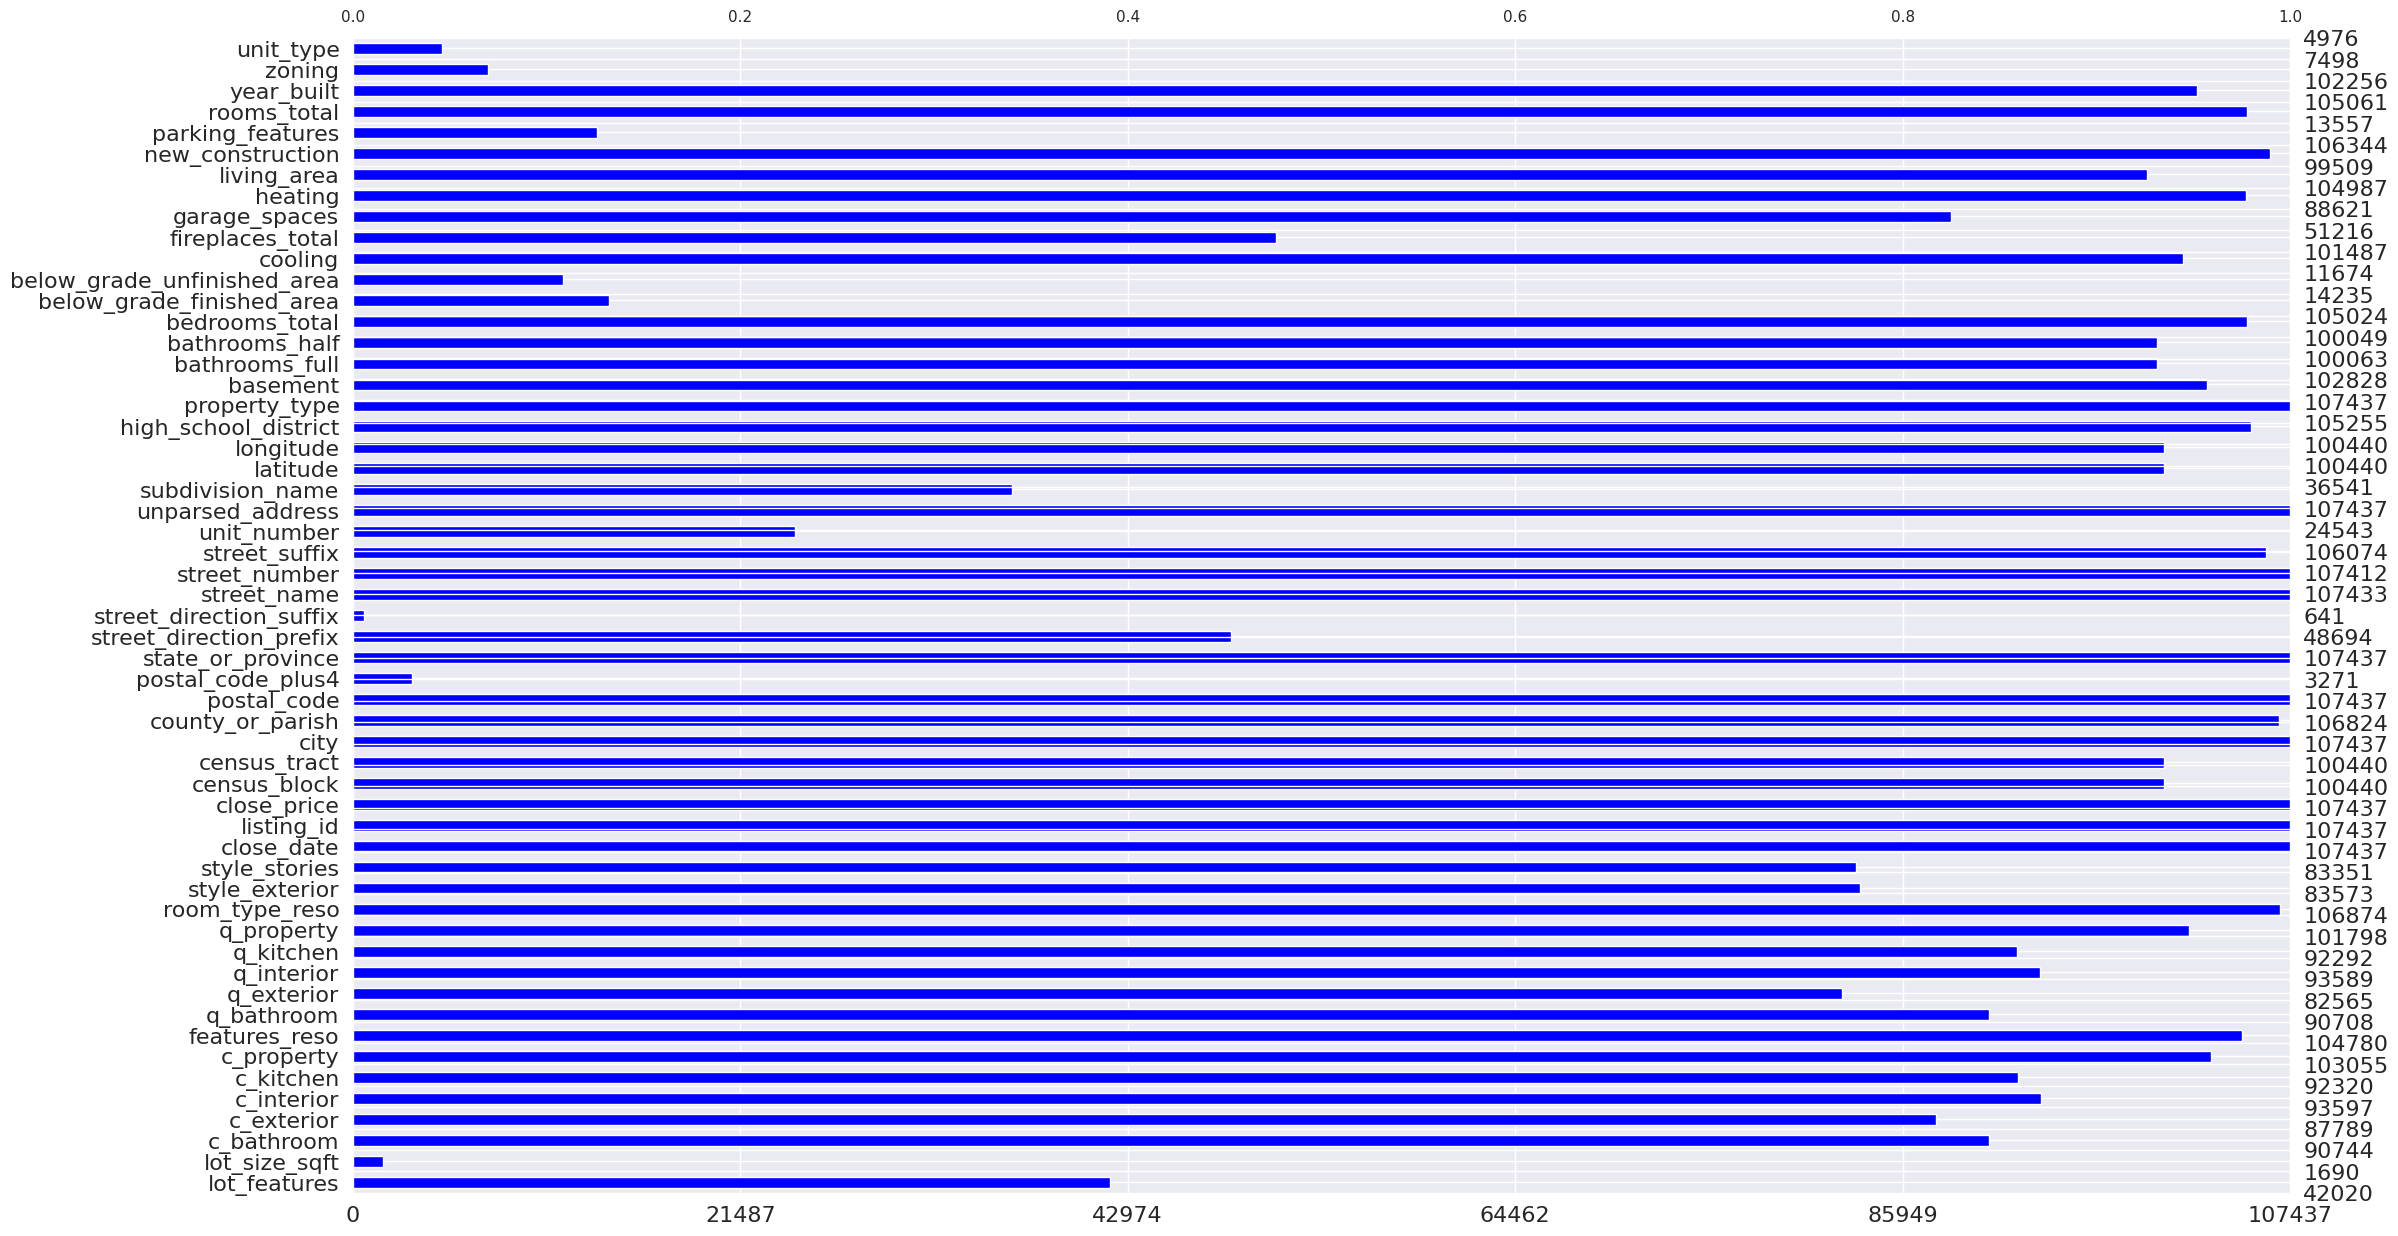

In [8]:
msno.bar(df_combined, color="blue")

Los valores perdidos pueden presentar patrones que pueden indicar cosas interesantes en los datos, pueden ser totalmente aleatorios o estar relacionados entre las diferentes columnas. Vamos a ver como són:

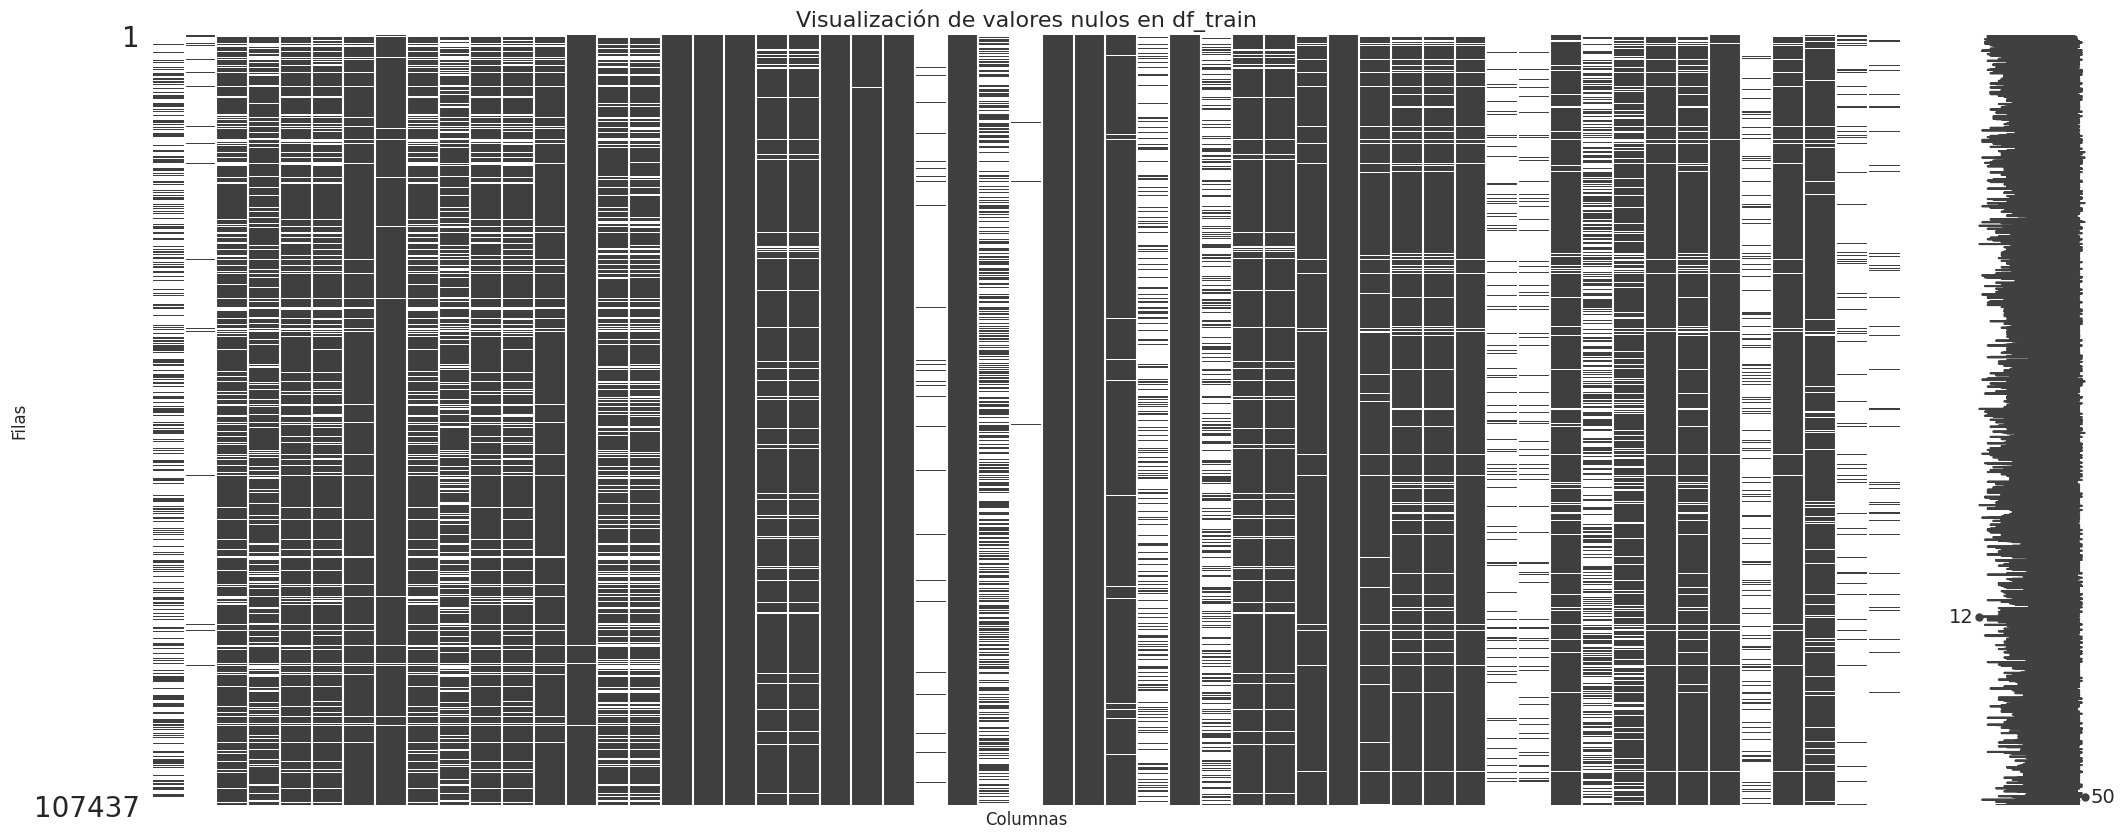

In [9]:
msno_plot = msno.matrix(df_combined)

msno_plot.set_title("Visualización de valores nulos en df_combined", fontsize=16)
msno_plot.set_xlabel("Columnas", fontsize=12)
msno_plot.set_ylabel("Filas", fontsize=12)

plt.show()

Vemos como en general no se sigue ningún patrón evidente en la aparición de valores perdidos. Hay varias opciones posibles para tratar los valores perdidos:
- Eliminar la variable con missing values
- Eliminarlas filas con missing values
- Tratar de imputar los missing values de alguna forma concreta


### Featrue preprocessing

In [10]:
for column in categorical_columns:
    print(f"Column: {column}")
    print(df_combined[column].value_counts())
    print("\n")

## Feature elimination

In [11]:
columns_with_many_missing = []

threshold = len(df_combined) * 0.5

for column in df_combined.columns:
    if df_combined[column].isna().sum() > threshold:
        columns_with_many_missing.append(column)

We also add the identifier variable that does not apport anything

In [12]:
columns_to_remove = columns_with_many_missing + ['listing_id', 'unparsed_address', 'street_number', 'street_suffix', 'state_or_province', 'street_name',
                                                 'census_block', 'census_tract', 'high_school_district', 'basement']

In [13]:
df_clean = df_combined.drop(columns=columns_to_remove, inplace=False)

In [14]:
df_clean.head()

,c_bathroom,c_exterior,c_interior,c_kitchen,c_property,features_reso,q_bathroom,q_exterior,q_interior,q_kitchen,...,bathrooms_full,bathrooms_half,bedrooms_total,cooling,garage_spaces,heating,living_area,new_construction,rooms_total,year_built
0,NaN,NaN,NaN,NaN,NaN,"['Cooling.CeilingFans', 'Flooring.Carpet', 'Fl...",NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,['central air'],NaN,NaN,NaN,False,NaN,0.0
1,NaN,3.8,3.7,3.8,3.8,"['Appliances.GasRange', 'Appliances.Range', 'A...",NaN,4.2,4.0,4.0,...,2.0,1.0,1.0,['window/wall unit - 1'],NaN,['natural gas'],3175.0,False,6.0,NaN
2,NaN,NaN,NaN,NaN,NaN,"['Flooring.Carpet', 'ParkingFeatures.Garage', ...",NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,['central air'],NaN,NaN,NaN,False,NaN,1926.0
3,NaN,NaN,NaN,NaN,NaN,"['CommunityFeatures.Lake', 'WaterfrontFeatures...",NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,NaN
4,NaN,3.6,NaN,NaN,3.6,"['Appliances.Refrigerator', 'Appliances.Microw...",NaN,4.2,NaN,NaN,...,1.0,0.0,2.0,"['partial', 'none']",NaN,['other'],0.0,False,4.0,2006.0


In [15]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107437 entries, 0 to 107436
Data columns (total 33 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   c_bathroom        90744 non-null   float64
 1   c_exterior        87789 non-null   float64
 2   c_interior        93597 non-null   float64
 3   c_kitchen         92320 non-null   float64
 4   c_property        103055 non-null  float64
 5   features_reso     104780 non-null  object 
 6   q_bathroom        90708 non-null   float64
 7   q_exterior        82565 non-null   float64
 8   q_interior        93589 non-null   float64
 9   q_kitchen         92292 non-null   float64
 10  q_property        101798 non-null  float64
 11  room_type_reso    106874 non-null  object 
 12  style_exterior    83573 non-null   object 
 13  style_stories     83351 non-null   object 
 14  close_date        107437 non-null  object 
 15  close_price       107437 non-null  float64
 16  city              10

In [16]:
df_clean['features_reso'] = df_clean['features_reso'].apply(lambda x: len(x) if isinstance(x, list) else 0)
df_clean['room_type_reso'] = df_clean['room_type_reso'].apply(lambda x: len(x) if isinstance(x, list) else 0)

In [17]:
df_clean['cooling'] = df_clean['cooling'].apply(lambda x: len(x) - 1 if isinstance(x, list) and 'none' in x else len(x) if isinstance(x, list) else 0)
df_clean['heating'] = df_clean['heating'].apply(lambda x: len(x) - 1 if isinstance(x, list) and 'none' in x else len(x) if isinstance(x, list) else 0)

In [18]:
unique_values_dict = {}

for column in df_clean.columns:
    if df_clean[column].dtype == 'object':
        unique_values = set()
        for value in df_clean[column].dropna():
            if isinstance(value, list):
                unique_values.update(value)
            else:
                unique_values.add(value)
        unique_values_dict[column] = list(unique_values)
        print(f"Column: {column}, Unique values: {len(unique_values)}")

Column: style_exterior, Unique values: 41
Column: style_stories, Unique values: 5
Column: close_date, Unique values: 353
Column: city, Unique values: 834
Column: county_or_parish, Unique values: 80
Column: postal_code, Unique values: 1477
Column: property_type, Unique values: 7
Column: basement, Unique values: 12
Column: new_construction, Unique values: 2


In [19]:
df_clean['county_or_parish'].unique()

array(['whiteside', 'lake', 'cook', 'will', 'kane', 'du page', 'iroquois',
       'champaign', 'mc henry', 'douglas', 'lee', 'de kalb', 'dekalb',
       'mchenry', 'kendall', 'rock island', 'grundy', 'putnam', 'boone',
       'livingston', 'carroll', 'winnebago', 'mc lean', 'bureau',
       'jo daviess', 'kankakee', 'lasalle', 'la salle', 'mclean',
       'de witt', 'ogle', 'stephenson', 'vermilion', 'warren', 'ford',
       'effingham', 'coles', 'macon', 'jasper', nan, 'christian',
       'crawford', 'shelby', 'cumberland', 'dupage', 'stark', 'edgar',
       'fayette', 'marshall', 'piatt', 'clark', 'moultrie', 'woodford',
       'other', 'peoria', 'mason', 'henry', 'tazewell', 'richland',
       'monroe', 'knox', 'logan', 'sangamon', 'clay', 'hancock', 'menard',
       'jefferson', 'madison', 'macoupin', 'fulton', 'st. clair',
       'saint clair', 'jackson', 'dewitt', 'gallatin', 'montgomery',
       'marion', 'lawrence', 'adams', 'hamilton', 'jersey'], dtype=object)

In [20]:
print(df_clean.columns)

Index(['c_bathroom', 'c_exterior', 'c_interior', 'c_kitchen', 'c_property',
       'features_reso', 'q_bathroom', 'q_exterior', 'q_interior', 'q_kitchen',
       'q_property', 'room_type_reso', 'style_exterior', 'style_stories',
       'close_date', 'close_price', 'city', 'county_or_parish', 'postal_code',
       'latitude', 'longitude', 'property_type', 'basement', 'bathrooms_full',
       'bathrooms_half', 'bedrooms_total', 'cooling', 'garage_spaces',
       'heating', 'living_area', 'new_construction', 'rooms_total',
       'year_built'],
      dtype='object')


### seguimos con preprocessing de categoricas

In [21]:
df_clean['cooling'].unique()

array([0])

In [27]:
sorted(df_clean['county_or_parish'].dropna().unique())


['adams',
 'boone',
 'bureau',
 'carroll',
 'champaign',
 'christian',
 'clark',
 'clay',
 'coles',
 'cook',
 'crawford',
 'cumberland',
 'de kalb',
 'de witt',
 'dekalb',
 'dewitt',
 'douglas',
 'du page',
 'dupage',
 'edgar',
 'effingham',
 'fayette',
 'ford',
 'fulton',
 'gallatin',
 'grundy',
 'hamilton',
 'hancock',
 'henry',
 'iroquois',
 'jackson',
 'jasper',
 'jefferson',
 'jersey',
 'jo daviess',
 'kane',
 'kankakee',
 'kendall',
 'knox',
 'la salle',
 'lake',
 'lasalle',
 'lawrence',
 'lee',
 'livingston',
 'logan',
 'macon',
 'macoupin',
 'madison',
 'marion',
 'marshall',
 'mason',
 'mc henry',
 'mc lean',
 'mchenry',
 'mclean',
 'menard',
 'monroe',
 'montgomery',
 'moultrie',
 'ogle',
 'other',
 'peoria',
 'piatt',
 'putnam',
 'richland',
 'rock island',
 'saint clair',
 'sangamon',
 'shelby',
 'st. clair',
 'stark',
 'stephenson',
 'tazewell',
 'vermilion',
 'warren',
 'whiteside',
 'will',
 'winnebago',
 'woodford']

In [ ]:
df_train_processed = df_combined[df_combined['origin'] == 'train'].drop(columns=['origin'])
df_test_processed = df_combined[df_combined['origin'] == 'test'].drop(columns=['origin'])

# Comprobamos que se mantienen las mismas filas
assert len(df_train) == len(df_train_processed)
assert len(df_test) == len(df_test_processed)